# Digit Recognizer
Taken from: https://www.kaggle.com/competitions/digit-recognizer/

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:



In [3]:
# Dépendances
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC



# Charger les données du training set
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

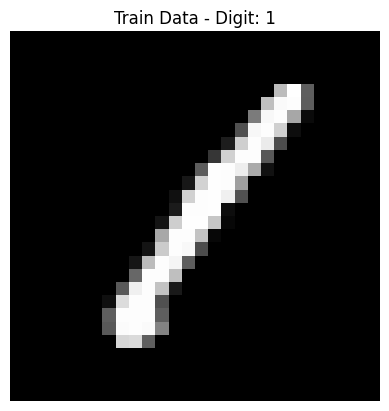

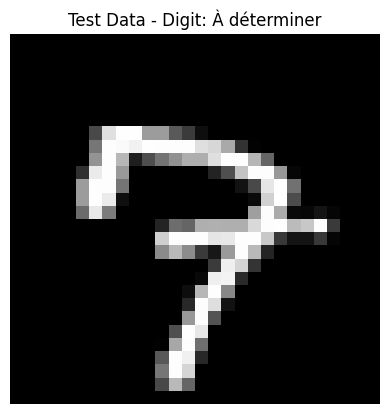

In [4]:
# Display one image using pixels
def display_digit(data, data_type, row_number, digit_value="À déterminer"):
    """
    Affiche une image à partir des données de luminance contenues dans les fichiers train.csv ou test.csv.

    Parameters:
        data (pd.DataFrame): Données à afficher (DataFrame chargé avec load_data).
        data_type (str): Type de données à afficher, soit 'train' soit 'test'.
        row_number (int): Numéro de la ligne à afficher (commence à 0).
        digit_value (str): Valeur du chiffre à afficher ("À déterminer" comme valeur par défaut).
    Returns:
        None: Affiche l'image avec Matplotlib.
    """
    # Vérifier le type de données si il s'agit des données d'entrainement (a le label) ou à déterminer (pas de label)
    if data_type == 'train':
        label = data.iloc[row_number, 0]
        pixel_values = data.iloc[row_number, 1:].values  
        title = f"Train Data - Digit: {label}"
    elif data_type == 'test':
        pixel_values = data.iloc[row_number].values
        title = f"Test Data - Digit: {digit_value}"
    else:
        raise ValueError("Le type de données doit être 'train' ou 'test'.")

    # Reshape des données pour obtenir une image 28x28
    image = pixel_values.reshape(28, 28)

    # Afficher l'image
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')  # Désactiver les axes
    plt.show()

# Afficher la ligne 0 des données d'entrainement
display_digit(train_data, 'train', 0)

# Afficher la ligne 5 des données de test
display_digit(test_data, 'test', 5)

In [5]:
def model_evaluation(model, train_data, scaler):
    """
    Évalue les performances du modèle sur les données d'entraînement et affiche une matrice de confusion colorée.
    Les erreurs sont proportionnellement colorées en rouge.

    Parameters:
        model (SVC): Le modèle SVM entraîné.
        train_data (pd.DataFrame): Les données d'entraînement, avec labels.
        scaler (StandardScaler): Le scaler utilisé pour standardiser les données.

    Returns:
        None: Affiche une matrice de confusion colorée.
    """
    # Séparer les features (pixels) et les labels
    X_train = train_data.iloc[:, 1:].values  # Pixels
    y_train = train_data.iloc[:, 0].values   # Labels

    # Standardiser les features
    X_train_scaled = scaler.transform(X_train)

    # Prédire les chiffres
    y_pred = model.predict(X_train_scaled)

    # Calculer la matrice de confusion
    cm = confusion_matrix(y_train, y_pred)

    # Créer une version normalisée de la matrice pour colorer les erreurs
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Masquer les cellules correctes pour éviter qu'elles ne soient rouges
    errors_only = normalized_cm.copy()
    np.fill_diagonal(errors_only, 0)  # Supprimer la diagonale

    # Tracer la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="coolwarm",
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        annot_kws={"fontsize": 10},
        mask=(errors_only == 0),  # Ne pas colorer les prédictions correctes
        alpha=0.8  # Transparence pour garder la lisibilité
    )

    plt.title("Matrice de confusion", fontsize=16)
    plt.xlabel("Prédictions", fontsize=12)
    plt.ylabel("Réel", fontsize=12)
    plt.show()

In [6]:
def predict_digit(model, test_data, scaler, row_number):
    """
    Utilise le modèle pour prédire un chiffre à partir des données de test.

    Parameters:
        model (SVC): Le modèle SVM entraîné.
        test_data (pd.DataFrame): Les données de test (sans labels).
        scaler (StandardScaler): Le scaler utilisé pour standardiser les données.
        row_number (int): Numéro de la ligne à prédire (commence à 0).
    
    Returns:
        None: Affiche l'image avec la prédiction.
    """
    # Extraire les données de la ligne
    pixel_values = test_data.iloc[row_number].values
    pixel_values_scaled = scaler.transform([pixel_values])  # Standardiser les données

    # Prédire le chiffre
    prediction = model.predict(pixel_values_scaled)[0]

    print(f"Prédiction pour la ligne {row_number}: {prediction}")
    display_digit(test_data, 'test', row_number, str(prediction))

In [7]:
def result(model, test_data, scaler, output_file):
    """
    Prédire les valeurs des chiffres pour toutes les lignes de test_data
    et enregistrer les résultats dans un fichier CSV.

    Parameters:
        model (SVC): Le modèle SVM entraîné.
        test_data (pd.DataFrame): Les données de test (sans labels).
        scaler (StandardScaler): Le scaler utilisé pour standardiser les données.
        output_file (str): Nom du fichier CSV de sortie.
    """
    results = []
    # Prédire les chiffres pour toutes les lignes de test_data
    for row_number in range(len(test_data)):
        pixel_values = test_data.iloc[row_number].values
        pixel_values_scaled = scaler.transform([pixel_values])
        prediction = model.predict(pixel_values_scaled)[0]
        results.append([row_number + 1, prediction])  # ImageId commence à 1

    # Créer un fichier CSV avec les résultats
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ImageId', 'Label'])
        writer.writerows(results)

    print(f"Résultats enregistrés dans le fichier {output_file}.")

Accuracy on validation set: 0.9171

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       827
           1       0.95      0.99      0.97       937
           2       0.89      0.92      0.90       835
           3       0.88      0.88      0.88       870
           4       0.90      0.93      0.92       814
           5       0.87      0.87      0.87       759
           6       0.97      0.95      0.96       827
           7       0.93      0.93      0.93       880
           8       0.92      0.83      0.88       813
           9       0.92      0.88      0.90       838

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



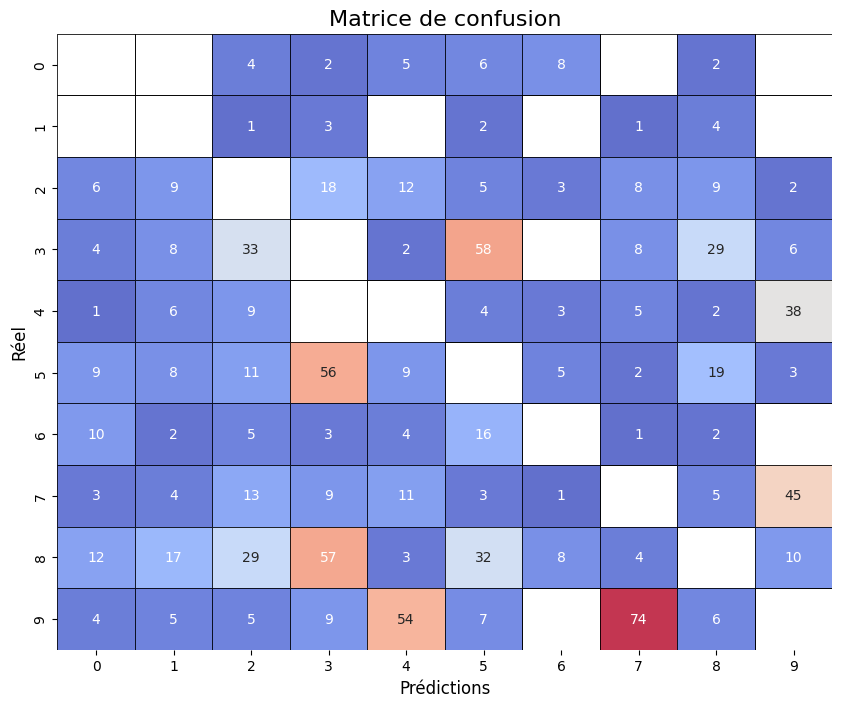

Prédiction pour la ligne 15: 5


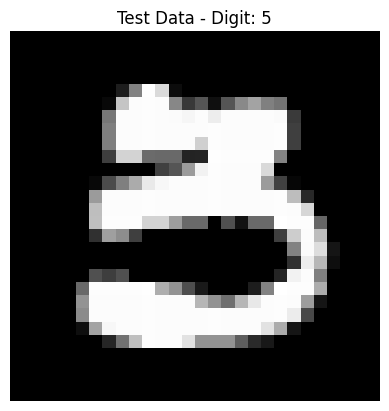

Prédiction pour la ligne 40: 7


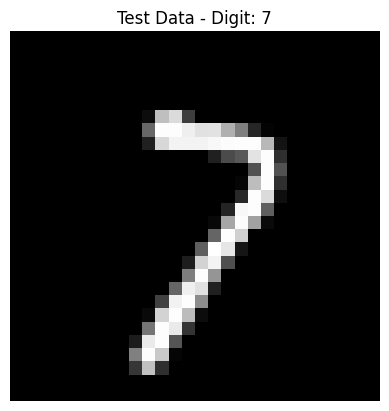

Résultats enregistrés dans le fichier predictions_svm.csv.


In [6]:
# Charger et préparer les données
X = train_data.iloc[:, 1:].values  # Features: les pixels
y = train_data.iloc[:, 0].values   # Labels: les chiffres

# Diviser les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardiser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Définir et entraîner un SVM avec un noyau linéaire
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred = svm.predict(X_val)

# Évaluer les performances
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")

# Afficher un rapport de classification
print("\nClassification Report:")
print(classification_report(y_val, y_pred))



# Matrice de confusion et visualisation
model_evaluation(svm, train_data, scaler)


# Fonction pour prédire un chiffre dans la liste des valeurs inconnues
predict_digit(svm, test_data, scaler, 15)
predict_digit(svm, test_data, scaler, 40)


# Fonction pour écrire les prédictions dans un fichier CSV
result(svm, test_data, scaler, 'predictions_svm.csv')

Accuracy on validation set: 0.9089

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       827
           1       0.94      0.99      0.96       937
           2       0.89      0.92      0.90       835
           3       0.86      0.87      0.86       870
           4       0.89      0.93      0.91       814
           5       0.85      0.86      0.86       759
           6       0.97      0.95      0.96       827
           7       0.93      0.91      0.92       880
           8       0.92      0.82      0.87       813
           9       0.89      0.86      0.87       838

    accuracy                           0.91      8400
   macro avg       0.91      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400



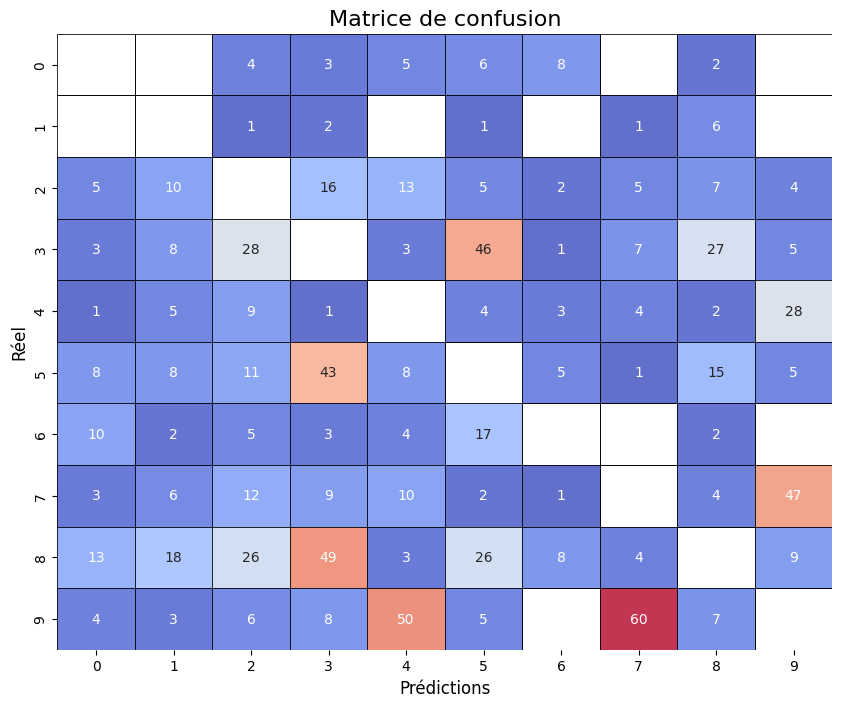

Prédiction pour la ligne 15: 5


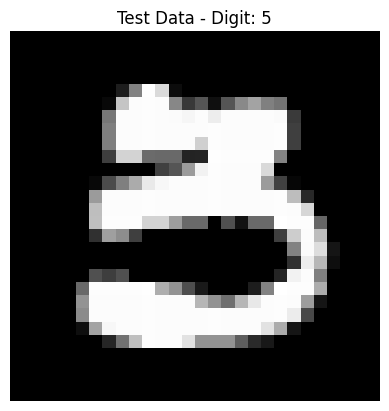

Prédiction pour la ligne 40: 7


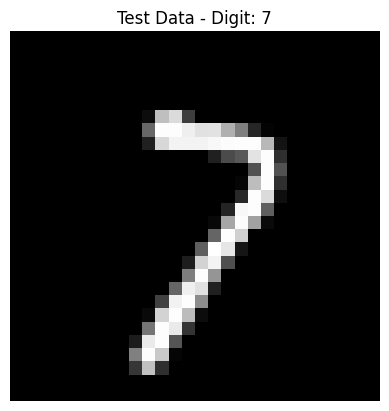

Résultats enregistrés dans le fichier predictions_svm.csv.


In [9]:
# Charger et préparer les données
X = train_data.iloc[:, 1:].values  # Features: les pixels
y = train_data.iloc[:, 0].values   # Labels: les chiffres

# Diviser les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardiser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Définir et entraîner un SVM avec un noyau linéaire
svm = SVC(kernel='linear', C=1E3, random_state=42)
svm.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred = svm.predict(X_val)

# Évaluer les performances
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")

# Afficher un rapport de classification
print("\nClassification Report:")
print(classification_report(y_val, y_pred))



# Matrice de confusion et visualisation
model_evaluation(svm, train_data, scaler)


# Fonction pour prédire un chiffre dans la liste des valeurs inconnues
predict_digit(svm, test_data, scaler, 15)
predict_digit(svm, test_data, scaler, 40)


# Fonction pour écrire les prédictions dans un fichier CSV
result(svm, test_data, scaler, 'predictions_svm.csv')

Accuracy on validation set: 0.9367

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       827
           1       0.95      0.99      0.97       937
           2       0.93      0.95      0.94       835
           3       0.91      0.90      0.91       870
           4       0.93      0.95      0.94       814
           5       0.90      0.89      0.89       759
           6       0.97      0.97      0.97       827
           7       0.95      0.94      0.94       880
           8       0.93      0.89      0.91       813
           9       0.92      0.91      0.91       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



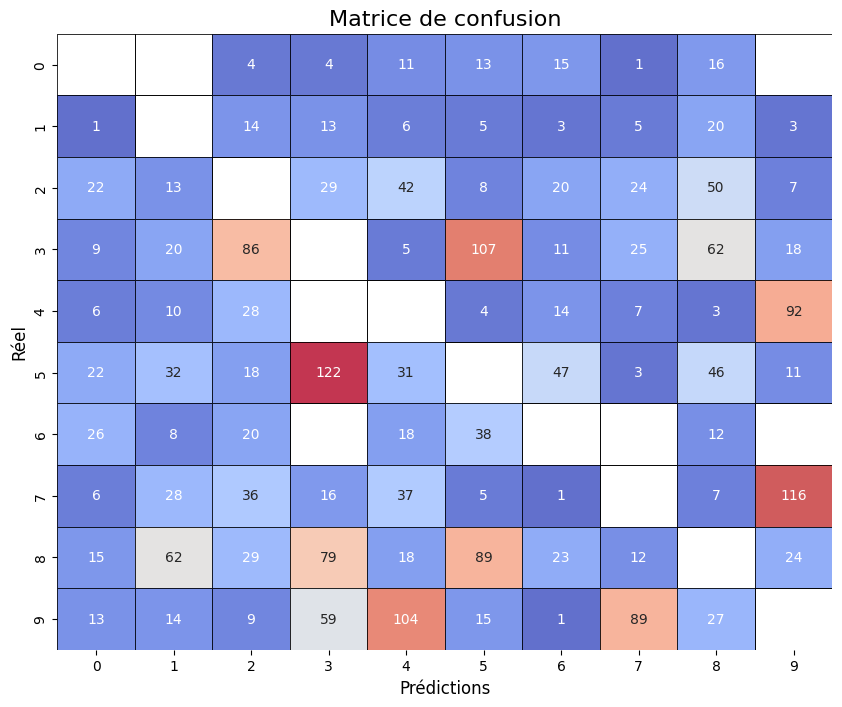

Prédiction pour la ligne 15: 3


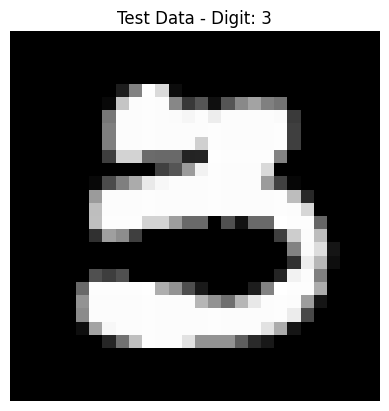

Prédiction pour la ligne 40: 7


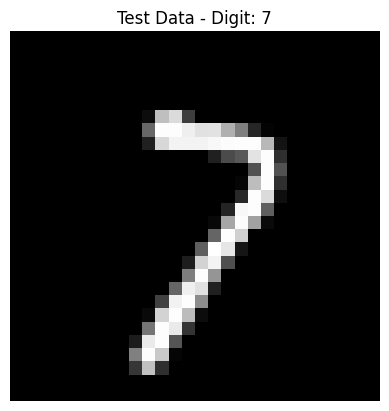

Résultats enregistrés dans le fichier predictions_svm.csv.


In [11]:
# Charger et préparer les données
X = train_data.iloc[:, 1:].values  # Features: les pixels
y = train_data.iloc[:, 0].values   # Labels: les chiffres

# Diviser les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardiser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Définir et entraîner un SVM avec un noyau linéaire
svm = SVC(kernel='linear', C=1E-3, random_state=42)
svm.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred = svm.predict(X_val)

# Évaluer les performances
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")

# Afficher un rapport de classification
print("\nClassification Report:")
print(classification_report(y_val, y_pred))



# Matrice de confusion et visualisation
model_evaluation(svm, train_data, scaler)


# Fonction pour prédire un chiffre dans la liste des valeurs inconnues
predict_digit(svm, test_data, scaler, 15)
predict_digit(svm, test_data, scaler, 40)


# Fonction pour écrire les prédictions dans un fichier CSV
result(svm, test_data, scaler, 'predictions_svm.csv')